In [ ]:
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
! pip install xclim
! pip install intake-esm

In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm  # Fancy progress bars for our loops!
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import cftime
import gcsfs
import xclim as xc
from xclim import ensembles
import tqdm
import intake
from google.colab import files
xr.set_options(display_style='html')
import dask
from dask.diagnostics import progress
import fsspec
import seaborn as sns

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
# [eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# there is currently a significant amount of data for these runs
expts = ['ssp245']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id='tas',
    # member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

In [ ]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    # assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    ds = ds.sel(lat=50, lon=-121,method='nearest')
    ds.coords['year'] = ds.time.dt.year
    ds.coords['time'] = xr.cftime_range(start=str(ds.time.dt.year.values[0]), 
                                    periods=len(ds.time.dt.year.values), 
                                    freq="MS", calendar="noleap")
    ds = ds.sel(time=slice('1950','2100'))
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in tqdm.tqdm(col_subset.df.groupby(by=['source_id', 'experiment_id'])):
    # print(group)
    dsets[group[0]][group[1]] = open_delayed(df)
    

In [ ]:
with progress.ProgressBar():
    dsets_ = dask.compute(dict(dsets))[0]

[########################################] | 100% Completed |  2min 37.9s


In [ ]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [ ]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm.tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt]
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim=expt_da)


100%|██████████| 24/24 [00:01<00:00, 13.28it/s]


In [ ]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [ ]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

<xarray.Dataset>
Dimensions:        (bnds: 2, experiment_id: 5, source_id: 24, time: 1812)
Coordinates:
  * source_id      (source_id) <U13 'ACCESS-CM2' ... 'NorESM2-MM'
  * bnds           (bnds) float64 1.0 2.0
  * time           (time) object 1950-01-01 00:00:00 ... 2100-12-01 00:00:00
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' ... 'ssp585'
Data variables:
    tas            (source_id, experiment_id, time) float32 279.27393 ... 282...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    creation_date:          2019-11-08T06:41:46Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCSS...
    grid:                   native atmosphere N96 grid (144x192 latxlon)
    grid_label:             gn
    history:                2019-11-08T06:41:46Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institution_id:         CSIRO-ARCCSS
    license:                CMIP6 model data produced by CSIRO is licensed un...
    mip_era:                CMIP6
    nominal_resolution:     250 km
    notes:                  Exp: CM2-historical; Local ID: bj594; Variable: t...
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       ACCESS-CM2
    parent_time_units:      days since 0950-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    run_variant:            forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2,...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    source_id:              ACCESS-CM2
    source_type:            AOGCM
    status:                 2020-01-26;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-CM2 output prepared for CMIP6
    tracking_id:            hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108

In [ ]:
df_all = big_ds.to_dataframe().reset_index()
df_all.index = pd.DatetimeIndex(df_all.time.astype(str),name='indextime')
df_all

,bnds,experiment_id,source_id,time,tas
indextime,,,,,
1950-01-01,1.0,historical,ACCESS-CM2,1950-01-01 00:00:00,279.273926
1950-02-01,1.0,historical,ACCESS-CM2,1950-02-01 00:00:00,274.301025
1950-03-01,1.0,historical,ACCESS-CM2,1950-03-01 00:00:00,276.474121
1950-04-01,1.0,historical,ACCESS-CM2,1950-04-01 00:00:00,280.382080
1950-05-01,1.0,historical,ACCESS-CM2,1950-05-01 00:00:00,281.412598
...,...,...,...,...,...
2100-08-01,2.0,ssp585,NorESM2-MM,2100-08-01 00:00:00,298.291992
2100-09-01,2.0,ssp585,NorESM2-MM,2100-09-01 00:00:00,294.731079
2100-10-01,2.0,ssp585,NorESM2-MM,2100-10-01 00:00:00,290.043274


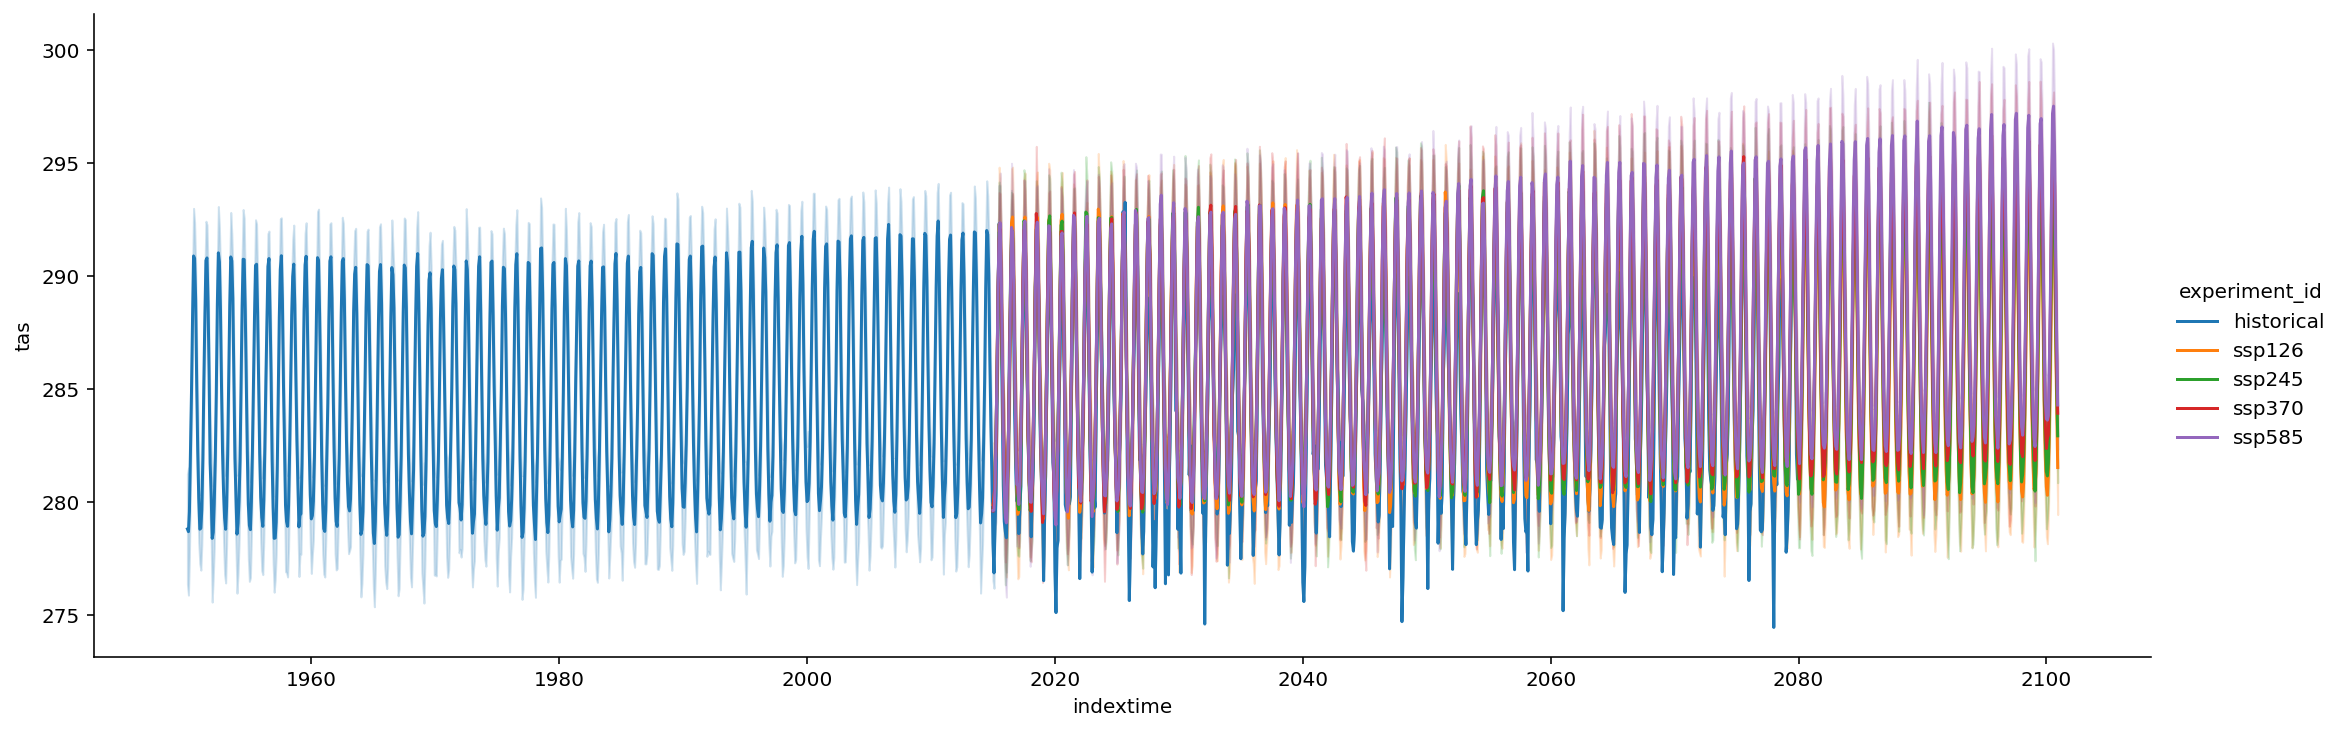

In [ ]:
sns.relplot(data=df_all,
            x="indextime", y="tas", hue='experiment_id',
            kind="line", ci="sd", aspect=3);

In [ ]:
ens = ensembles.create_ensemble(big_ds.tas)

ens

<xarray.Dataset>
Dimensions:        (experiment_id: 5, realization: 24, year: 451)
Coordinates:
    source_id      (realization) <U13 'ACCESS-CM2' ... 'NorESM2-MM'
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.299e+03 2.3e+03
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' ... 'ssp585'
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    tas            (realization, experiment_id, year) float64 287.0 ... nan

/usr/local/lib/python3.6/dist-packages/xclim/ensembles.py:248: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={"percentiles": len(values)},


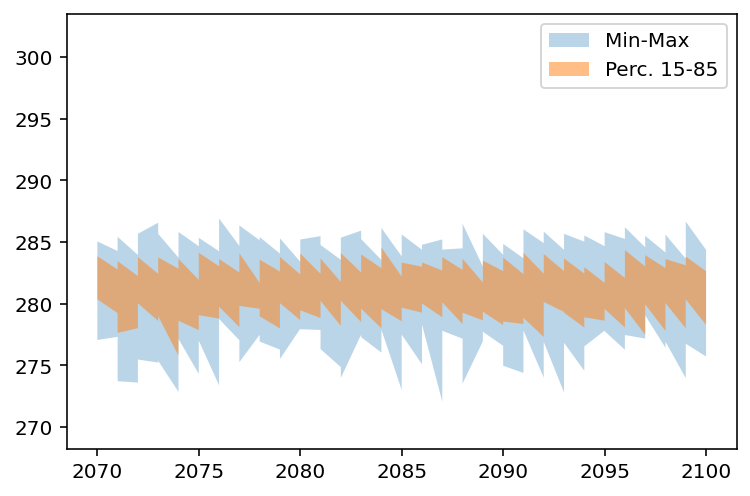

In [ ]:
# previous cells were pulled from the pangeo sample.
# the creation of the big_ds dataset is very efficient to work from
ens = ensembles.create_ensemble(big_ds.tas)

def plotset(ensemble,start,end,exp):
  ens = ens.sel(time=slice(start, end))
  ens = ens.sel(experiment_id=(exp))
  ens_perc = ensembles.ensemble_percentiles(ens, values=[15, 50, 85], split=False)
  ens_stats = ensembles.ensemble_mean_std_max_min(ens)

# def shiftfactor
